Using EnsemPredicting future prices of stocks using technical indicators as features 

In [ ]:
import os
import numpy as np
import pandas as pd
import pandas.testing as tm


#ML Models
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import StackingRegressor


# Visualisation
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


#Data
!pip install yfinance
import yfinance as yf

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

In [ ]:
start_date="2015-01-01"
end_date="2020-12-31"
df = yf.Ticker('OFSS.NS').history(start=start_date,  end=end_date)
df.reset_index()
df['Date'] = pd.to_datetime(df.index)
df.index = range(len(df))
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Date
1472,2969.067114,2986.896743,2930.712283,2973.891113,65530,0.0,0,2020-12-23
1473,2988.552035,3094.867058,2980.417512,3045.682129,137758,0.0,0,2020-12-24
1474,3055.140681,3069.328641,2989.355795,3009.644531,131011,0.0,0,2020-12-28
1475,3022.035467,3076.422647,3022.035467,3038.493408,69539,0.0,0,2020-12-29
1476,3053.958425,3063.180600,3028.656563,3050.553223,32849,0.0,0,2020-12-30


In [ ]:
#OHLC
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=df.Date,
                      open=df.Open,
                      high=df.High,
                      low=df.Low,
                      close=df.Close,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=df.Date, y=df.Volume, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

#Adding Features 

In [ ]:
df['EMA_9'] = df['Close'].ewm(9).mean().shift()
df['EMA_20'] = df['Close'].ewm(20).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_20'] = df['Close'].rolling(20).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()


fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Date, y=df.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=df.Date, y=df.EMA_20, name='EMA 20'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_20, name='SMA 20'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close', opacity=0.2))
fig.show()

In [ ]:
def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

fig = go.Figure(go.Scatter(x=df.Date, y=df.RSI, name='RSI'))
fig.show()

In [ ]:
EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

In [ ]:
df['Close'] = df['Close'].shift(-1)

In [ ]:
df = df.iloc[33:] # Because of moving averages and MACD line
df = df[:-1]      # Because of shifting close price

df.index = range(len(df))

In [ ]:
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,EMA_9,EMA_20,SMA_5,SMA_10,SMA_20,SMA_30,RSI,MACD,MACD_signal
count,1443.000000,1443.000000,1443.000000,1443.000000,1.443000e+03,1443.000000,1443.0,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000
mean,2856.521744,2894.710648,2817.963614,2854.864020,4.121379e+04,0.616771,0.0,2850.813058,2847.102025,2853.285303,2852.337651,2850.567165,2848.953643,50.650664,2.420925,2.375511
std,344.563030,345.019216,342.700370,343.325541,5.817802e+04,9.745409,0.0,331.700915,319.205178,341.597420,339.742111,335.787517,331.756466,16.809519,48.938392,45.919173
min,1373.683788,1452.004004,1325.283617,1386.575806,1.979000e+03,0.000000,0.0,1782.607139,1936.284071,1467.932031,1571.789905,1704.311670,1755.348157,3.177515,-267.830509,-226.809773
25%,2627.746856,2662.413750,2595.805067,2631.574707,1.742850e+04,0.000000,0.0,2633.428470,2644.713437,2623.000439,2624.630127,2631.848956,2635.395036,38.503343,-25.681785,-23.280687
50%,2884.885385,2917.376995,2847.773855,2882.294189,2.758600e+04,0.000000,0.0,2884.277468,2899.085139,2879.815430,2882.364526,2879.319604,2878.306006,50.517198,2.673552,2.051555
75%,3054.922319,3091.147960,3016.184804,3050.012817,4.397200e+04,0.000000,0.0,3034.665257,3030.028969,3054.024121,3047.559875,3035.600293,3027.035954,63.047904,29.420286,27.417647
max,3973.167008,4099.403171,3722.542067,3950.947021,1.036259e+06,180.000000,0.0,3653.814961,3545.891576,3777.463086,3696.665723,3652.449976,3614.213883,92.084446,127.100303,109.757584


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1443 entries, 0 to 1442
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Open          1443 non-null   float64       
 1   High          1443 non-null   float64       
 2   Low           1443 non-null   float64       
 3   Close         1443 non-null   float64       
 4   Volume        1443 non-null   int64         
 5   Dividends     1443 non-null   float64       
 6   Stock Splits  1443 non-null   int64         
 7   Date          1443 non-null   datetime64[ns]
 8   EMA_9         1443 non-null   float64       
 9   EMA_20        1443 non-null   float64       
 10  SMA_5         1443 non-null   float64       
 11  SMA_10        1443 non-null   float64       
 12  SMA_20        1443 non-null   float64       
 13  SMA_30        1443 non-null   float64       
 14  RSI           1443 non-null   float64       
 15  MACD          1443 non-null   float64 

##Splitting the data for training, validation and testing

In [ ]:
test_size  = 0.10
valid_size = 0.10

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.Close, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.Close, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.Close,  name='Test'))
fig.show()

In [ ]:
drop_cols = ['Date', 'Open','Volume', 'Dividends','Stock Splits']

train_df = train_df.drop(drop_cols, 1)
valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1155 entries, 0 to 1154
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   High         1155 non-null   float64
 1   Low          1155 non-null   float64
 2   Close        1155 non-null   float64
 3   EMA_9        1155 non-null   float64
 4   EMA_20       1155 non-null   float64
 5   SMA_5        1155 non-null   float64
 6   SMA_10       1155 non-null   float64
 7   SMA_20       1155 non-null   float64
 8   SMA_30       1155 non-null   float64
 9   RSI          1155 non-null   float64
 10  MACD         1155 non-null   float64
 11  MACD_signal  1155 non-null   float64
dtypes: float64(12)
memory usage: 108.4 KB


In [ ]:
y_train = train_df['Close'].copy()
X_train = train_df.drop(['Close'], 1)

y_valid = valid_df['Close'].copy()
X_valid = valid_df.drop(['Close'], 1)

y_test  = test_df['Close'].copy()
X_test  = test_df.drop(['Close'], 1)

#Boosting - XGBoost

In [ ]:
%%time
parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.07, 0.1],
    'max_depth': [ 2, 4, 6, 8],
    'gamma': [0, 0.0005, 0.001, 0.005, 0.01],
    'random_state': [2, 4, 8, 12]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'random_state': 2}
Best validation score = 0.734535337605976
CPU times: user 34min 55s, sys: 18 s, total: 35min 14s
Wall time: 35min 5s


In [ ]:
%%time
model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

CPU times: user 212 ms, sys: 3 ms, total: 215 ms
Wall time: 213 ms


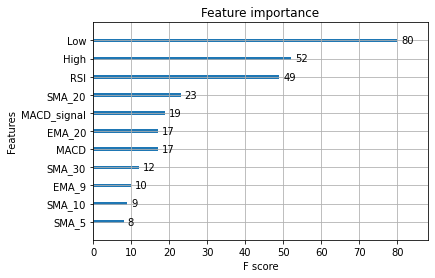

In [ ]:
plot_importance(model)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

mean_squared_error = 2810.2290141661133


In [ ]:
model.score(X_test,y_test)  #R2 score --- Regression

0.8679834193280955

In [ ]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close,
                         name='Truth',
                         marker_color='Blue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='Red'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_test,
                         name='True',
                         marker_color='Blue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_pred,
                         name='Prediction',
                         marker_color='Red',
                         showlegend=False), row=2, col=1)

fig.show()

#Random Forest Regressor

In [ ]:
RFReg = RandomForestRegressor(random_state = 1, n_jobs = -1) 
RFReg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [ ]:
y_pred1 = RFReg.predict(X_test)

In [ ]:
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred1)}')

mean_squared_error = 3378.573537456119


In [ ]:
RFReg.score(X_test,y_test)

0.841284207189111

In [ ]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred1

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close,
                         name='True',
                         marker_color='Blue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Close,
                         name='Predicted',
                         marker_color='Red'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_test,
                         name='True',
                         marker_color='Blue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_pred1,
                         name='Predicted',
                         marker_color='Red',
                         showlegend=False), row=2, col=1)

fig.show()

#Stacking

In [ ]:
estimators = [('Random Forest', RFReg),
              ('XGBoost', model)]
#Stack these models with StackingRegressor
stacking_regressor = StackingRegressor(estimators=estimators,
                                       final_estimator=RidgeCV())
stacking_regressor.fit(X_train, y_train)

StackingRegressor(cv=None,
                  estimators=[('Random Forest',
                               RandomForestRegressor(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                          

In [ ]:
y_pred2 = stacking_regressor.predict(X_test)

In [ ]:
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred2)}')

mean_squared_error = 3743.0567617617166


In [ ]:
stacking_regressor.score(X_test,y_test)

0.8241618201016039

In [ ]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred2
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close,
                         name='True',
                         marker_color='Blue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Close,
                         name='Predicted',
                         marker_color='Red'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_test,
                         name='True',
                         marker_color='Blue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_pred2,
                         name='Predicted',
                         marker_color='Red',
                         showlegend=False), row=2, col=1)

fig.show()